## Importing

In [20]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor

from sklearn.metrics import mean_squared_error as mse

from tqdm.auto import tqdm

import dill
import random

import salishsea_tools.viz_tools as sa_vi


## Datasets Preparation

In [21]:
def datasets_preparation(dataset):
    
    drivers = np.stack([np.ravel(dataset['Temperature_(0m-15m)']),
        np.ravel(dataset['Temperature_(15m-100m)']), np.ravel(dataset['Salinity_(0m-15m)']),
        np.ravel(dataset['Salinity_(15m-100m)'])])
    indx = np.where(~np.isnan(drivers).any(axis=0))
    drivers = drivers[:,indx[0]]

    diat = np.ravel(dataset['Flagellate'])
    diat = diat[indx[0]]

    return(drivers, diat, indx)

## Regressor

In [22]:
def regressor (inputs, targets):
    
    inputs = inputs.transpose()
    
    # Regressor
    scale = preprocessing.StandardScaler()
    inputs = scale.fit_transform(inputs)
    X_train, _, y_train, _ = train_test_split(inputs, targets, train_size=0.35)

    drivers = None
    diat = None
    
    inputs = None
    targets = None

    model = MLPRegressor(hidden_layer_sizes=200, alpha=0.002)
    regr = BaggingRegressor(model, n_estimators=12, n_jobs=4).fit(X_train, y_train) 

    return (regr)

## Regressor 2

In [23]:
def regressor2 (inputs, targets, variable_name):
    
    inputs = inputs.transpose()
    
    # Regressor
    scale = preprocessing.StandardScaler()
    inputs2 = scale.fit_transform(inputs)

    outputs_test = regr.predict(inputs2)
   
    m = scatter_plot(targets, outputs_test, variable_name) 
    r = np.round(np.corrcoef(targets, outputs_test)[0][1],3)
    rms = mse(targets, outputs_test)

    return (r, rms, m)

## Regressor 3

In [24]:
def regressor3 (inputs, targets):
    
    inputs = inputs.transpose()
    
    # Regressor
    scale = preprocessing.StandardScaler()
    inputs2 = scale.fit_transform(inputs)

    outputs_test = regr.predict(inputs2)
   
    # compute slope m and intercept b
    m, b = np.polyfit(targets, outputs_test, deg=1)
    
    r = np.round(np.corrcoef(targets, outputs_test)[0][1],3)
    rms = mse(targets, outputs_test)

    return (r, rms, m)

## Regressor 4

In [25]:
def regressor4 (inputs, targets, variable_name):
    
    inputs = inputs.transpose()
    
    # Regressor
    scale = preprocessing.StandardScaler()
    inputs2 = scale.fit_transform(inputs)

    outputs = regr.predict(inputs2)

    # Post processing
    indx2 = np.full((len(flag_i.y)*len(flag_i.x)),np.nan)
    indx2[indx[0]] = outputs
    model = np.reshape(indx2,(len(flag_i.y),len(flag_i.x)))

    m = scatter_plot(targets, outputs, variable_name + str(dates[i].date())) 

    # Preparation of the dataarray 
    model = xr.DataArray(model,
        coords = {'y': flag_i.y, 'x': flag_i.x},
        dims = ['y','x'],
        attrs=dict( long_name = variable_name + "Concentration",
        units="mmol m-2"),)
                        
    plotting3(targets, model, flag_i, variable_name)

## Printing

In [26]:
def printing (targets, outputs, m):

    print ('The amount of data points is', outputs.size)
    print ('The slope of the best fitting line is ', np.round(m,3))
    print ('The correlation coefficient is:', np.round(np.corrcoef(targets, outputs)[0][1],3))
    print (' The mean square error is:', mse(targets,outputs))


## Scatter Plot

In [27]:
def scatter_plot(targets, outputs, variable_name):

    # compute slope m and intercept b
    m, b = np.polyfit(targets, outputs, deg=1)

    printing(targets, outputs, m)

    fig, ax = plt.subplots(2, figsize=(5,10), layout='constrained')

    ax[0].scatter(targets,outputs, alpha = 0.2, s = 10)

    lims = [np.min([ax[0].get_xlim(), ax[0].get_ylim()]),
        np.max([ax[0].get_xlim(), ax[0].get_ylim()])]

    # plot fitted y = m*x + b
    ax[0].axline(xy1=(0, b), slope=m, color='r')

    ax[0].set_xlabel('targets')
    ax[0].set_ylabel('outputs')
    ax[0].set_xlim(lims)
    ax[0].set_ylim(lims)
    ax[0].set_aspect('equal')

    ax[0].plot(lims, lims,linestyle = '--',color = 'k')

    h = ax[1].hist2d(targets,outputs, bins=100, cmap='jet', 
        range=[lims,lims], cmin=0.1, norm='log')
    
    ax[1].plot(lims, lims,linestyle = '--',color = 'k')

    # plot fitted y = m*x + b
    ax[1].axline(xy1=(0, b), slope=m, color='r')

    ax[1].set_xlabel('targets')
    ax[1].set_ylabel('outputs')
    ax[1].set_aspect('equal')

    fig.colorbar(h[3],ax=ax[1], location='bottom')

    fig.suptitle(variable_name)

    plt.show()

    return (m)


## Plotting

In [28]:
def plotting(variable, name):

    plt.plot(years,variable, marker = '.', linestyle = '')
    plt.xlabel('Years')
    plt.ylabel(name)
    plt.show()

## Plotting 2

In [29]:
def plotting2(variable,title):
    
    fig, ax = plt.subplots()

    scatter= ax.scatter(dates,variable, marker='.', c=pd.DatetimeIndex(dates).month)

    ax.legend(handles=scatter.legend_elements()[0], labels=['February','March','April'])
    fig.suptitle('Daily ' + title + ' (15 Feb - 30 Apr)')
    
    fig.show()

## Plotting 3

In [30]:
def plotting3(targets, model, variable, variable_name):

    fig, ax = plt.subplots(2,2, figsize = (10,15))

    cmap = plt.get_cmap('cubehelix')
    cmap.set_bad('gray')

    variable.plot(ax=ax[0,0], cmap=cmap, vmin = targets.min(), vmax =targets.max(), cbar_kwargs={'label': variable_name + ' Concentration  [mmol m-2]'})
    model.plot(ax=ax[0,1], cmap=cmap, vmin = targets.min(), vmax = targets.max(), cbar_kwargs={'label': variable_name + ' Concentration  [mmol m-2]'})
    ((variable-model) / variable * 100).plot(ax=ax[1,0], cmap=cmap, cbar_kwargs={'label': variable_name + ' Concentration  [percentage]'})

    plt.subplots_adjust(left=0.1,
        bottom=0.1, 
        right=0.95, 
        top=0.95, 
        wspace=0.35, 
        hspace=0.35)

    sa_vi.set_aspect(ax[0,0])
    sa_vi.set_aspect(ax[0,1])
    sa_vi.set_aspect(ax[1,0])


    ax[0,0].title.set_text(variable_name + ' (targets)')
    ax[0,1].title.set_text(variable_name + ' (outputs)')
    ax[1,0].title.set_text('targets - outputs')
    ax[1,1].axis('off')

    fig.suptitle(str(dates[i].date()))

    plt.show()
    

## Training (Random Points)

In [31]:
ds = xr.open_dataset('/data/ibougoudis/MOAD/files/integrated_model_var_old.nc')

ds = ds.isel(time_counter = (np.arange(0, len(ds.Diatom.time_counter),2)), 
    y=(np.arange(ds.y[0], ds.y[-1], 5)), 
    x=(np.arange(ds.x[0], ds.x[-1], 5)))

dates = pd.DatetimeIndex(ds['time_counter'].values)

drivers, flag, _ = datasets_preparation(ds)

regr = regressor(drivers, flag)


## Other Years (Anually)

  0%|          | 0/17 [00:00<?, ?it/s]

The amount of data points is 70794
The slope of the best fitting line is  0.646
The correlation coefficient is: 0.84
 The mean square error is: 0.00023455212


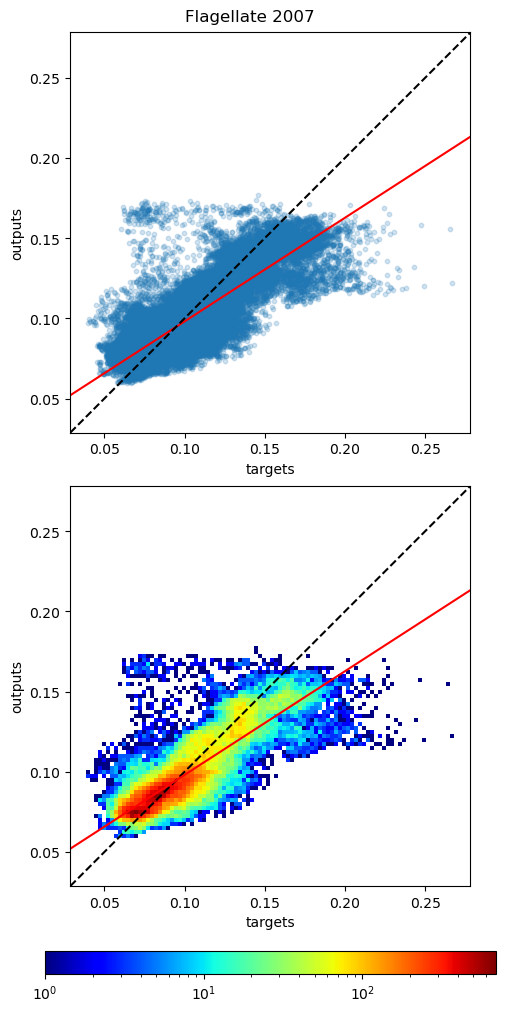

The amount of data points is 70794
The slope of the best fitting line is  0.611
The correlation coefficient is: 0.832
 The mean square error is: 0.0002731807


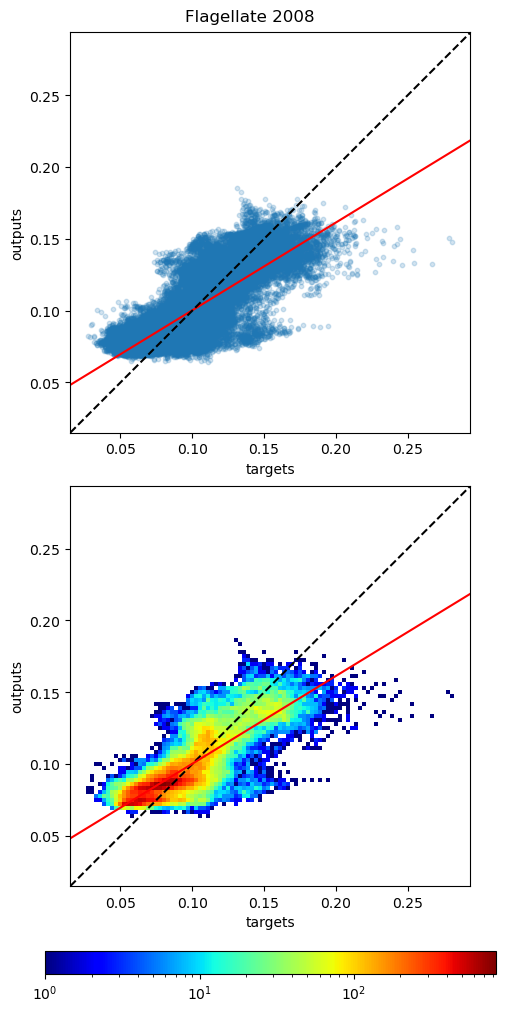

The amount of data points is 68931
The slope of the best fitting line is  0.66
The correlation coefficient is: 0.808
 The mean square error is: 0.00027071804


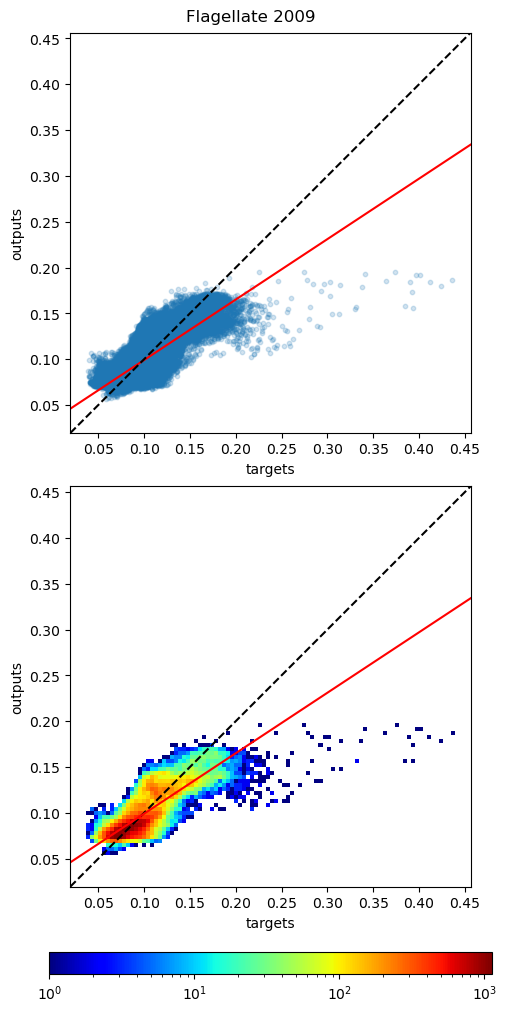

The amount of data points is 70794
The slope of the best fitting line is  0.516
The correlation coefficient is: 0.622
 The mean square error is: 0.0005068728


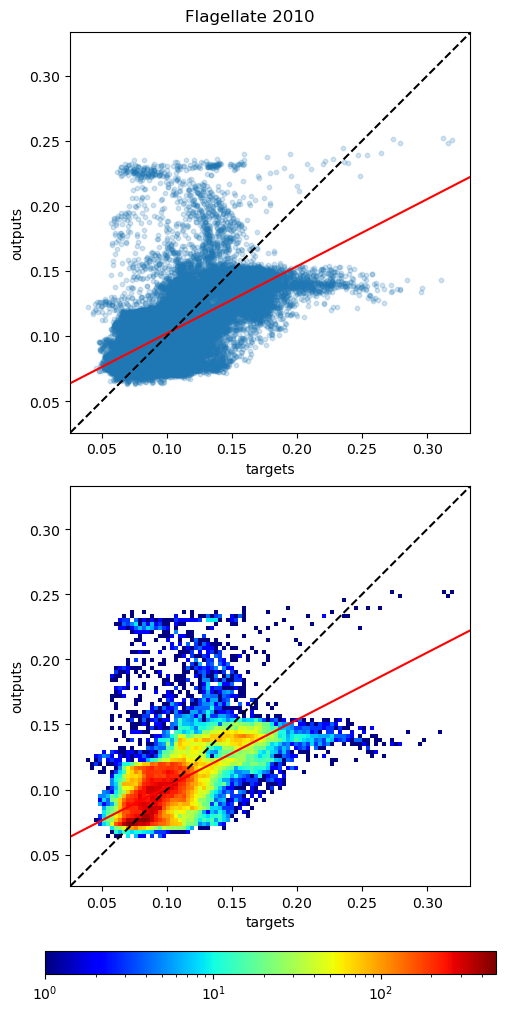

The amount of data points is 68931
The slope of the best fitting line is  0.468
The correlation coefficient is: 0.74
 The mean square error is: 0.00052570115


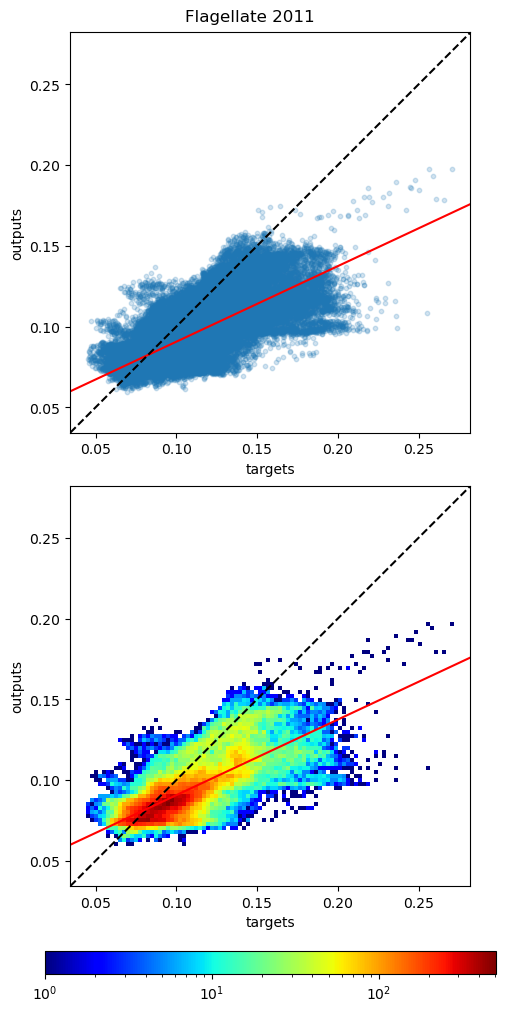

The amount of data points is 70794
The slope of the best fitting line is  0.607
The correlation coefficient is: 0.815
 The mean square error is: 0.00029588162


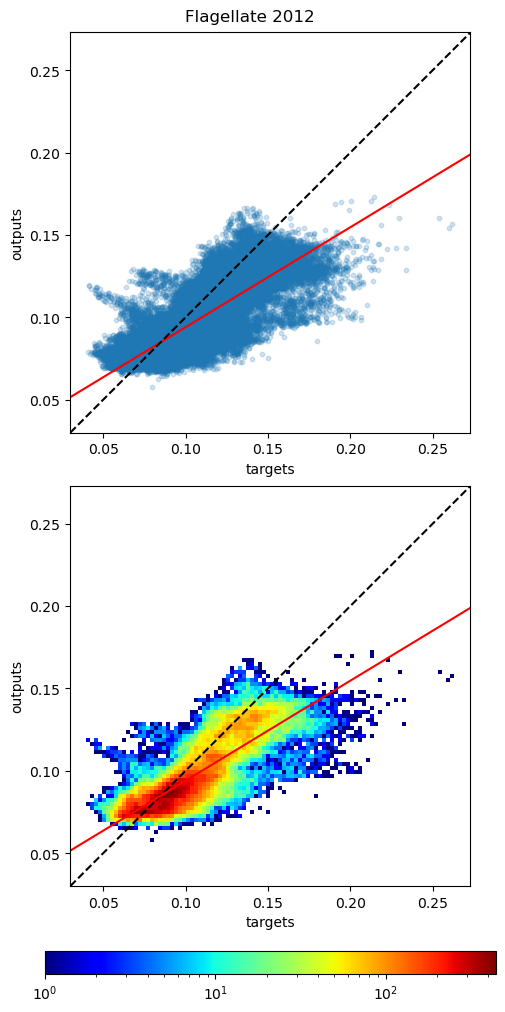

The amount of data points is 70794
The slope of the best fitting line is  0.758
The correlation coefficient is: 0.824
 The mean square error is: 0.00019561333


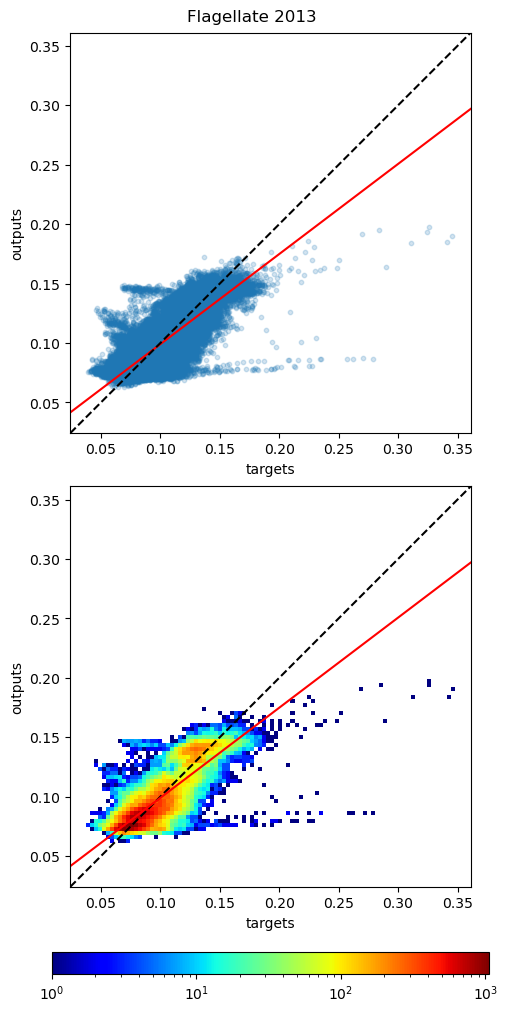

The amount of data points is 68931
The slope of the best fitting line is  0.67
The correlation coefficient is: 0.816
 The mean square error is: 0.00032206246


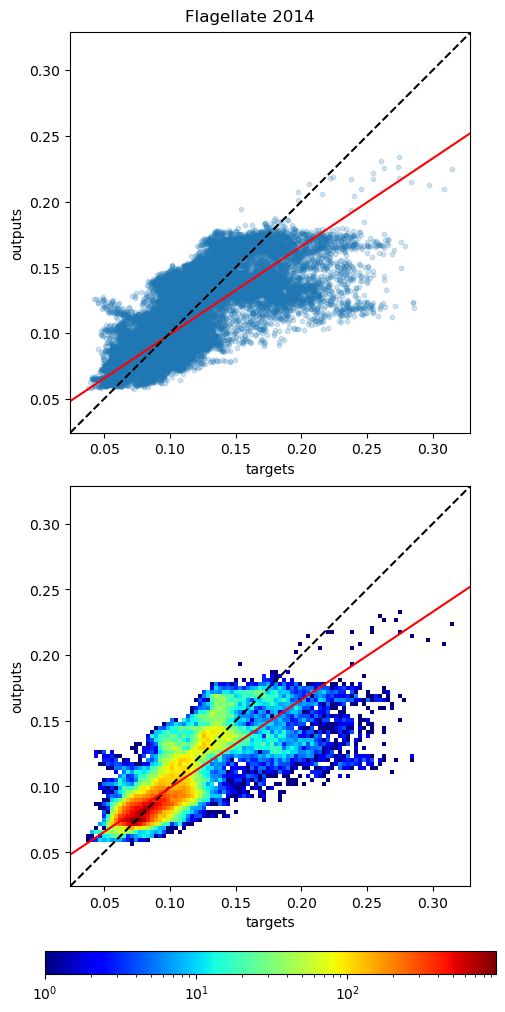

The amount of data points is 70794
The slope of the best fitting line is  0.54
The correlation coefficient is: 0.452
 The mean square error is: 0.0007385124


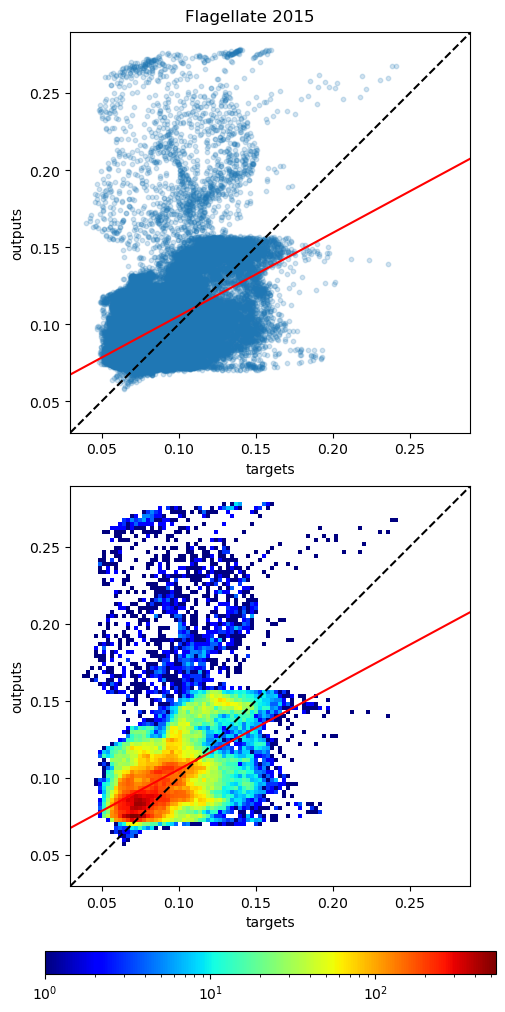

The amount of data points is 70794
The slope of the best fitting line is  0.622
The correlation coefficient is: 0.608
 The mean square error is: 0.00059062446


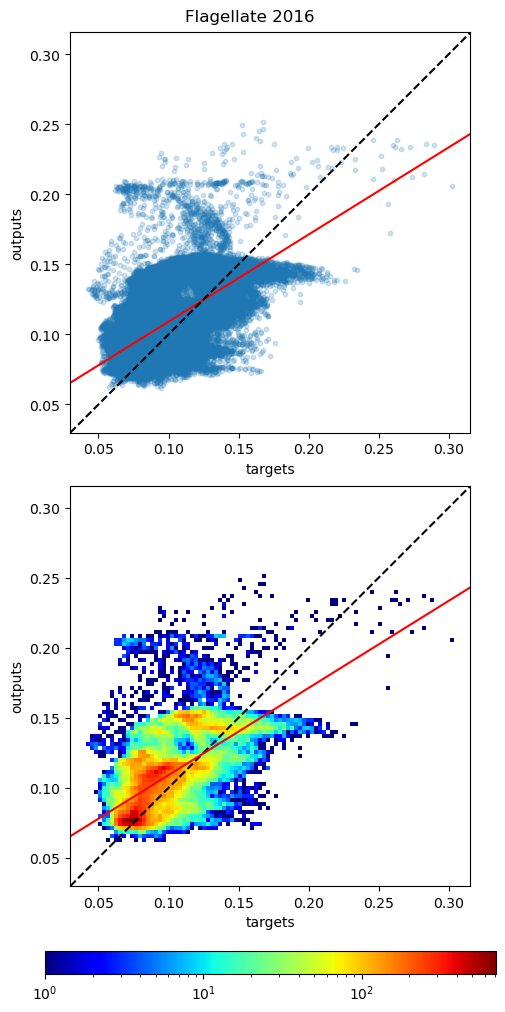

The amount of data points is 68931
The slope of the best fitting line is  0.553
The correlation coefficient is: 0.718
 The mean square error is: 0.0003204393


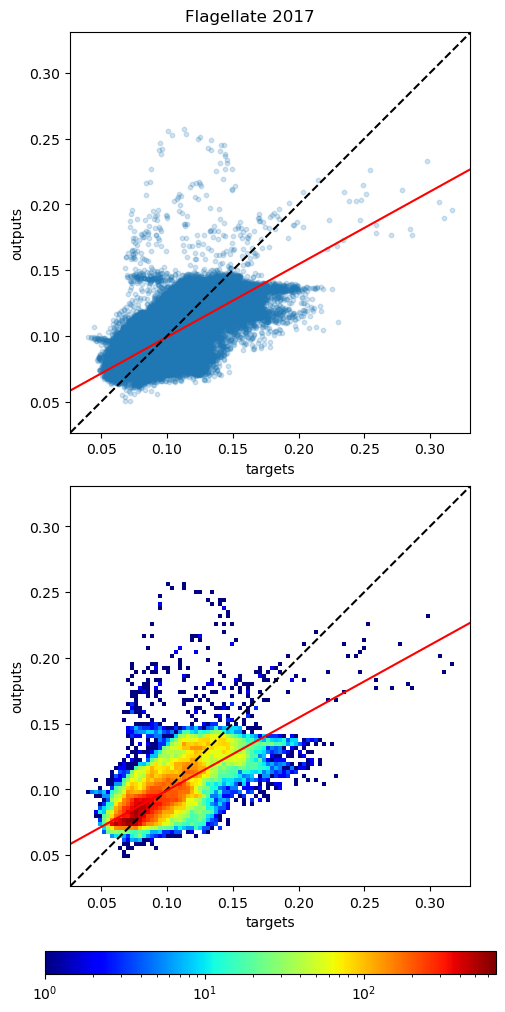

The amount of data points is 70794
The slope of the best fitting line is  0.516
The correlation coefficient is: 0.747
 The mean square error is: 0.00031121154


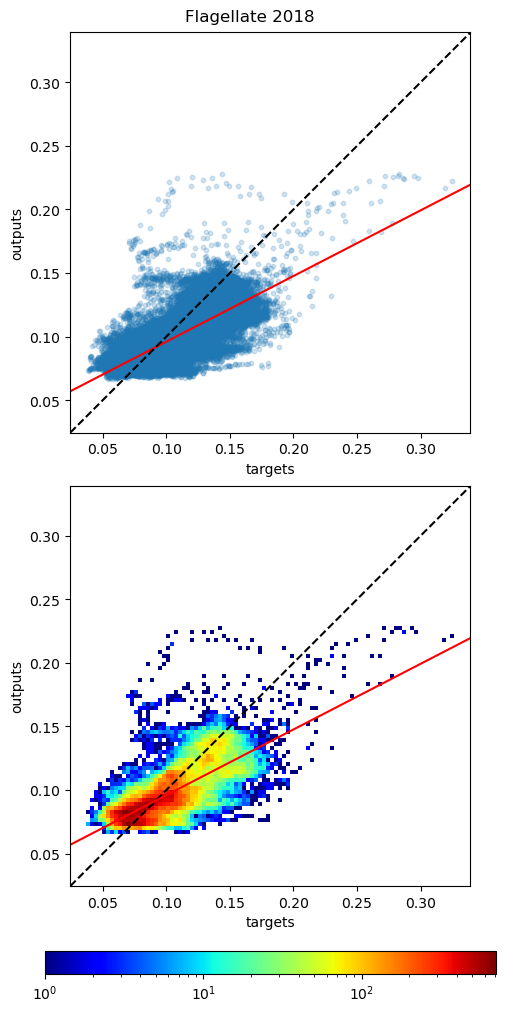

The amount of data points is 68931
The slope of the best fitting line is  0.584
The correlation coefficient is: 0.801
 The mean square error is: 0.00025878055


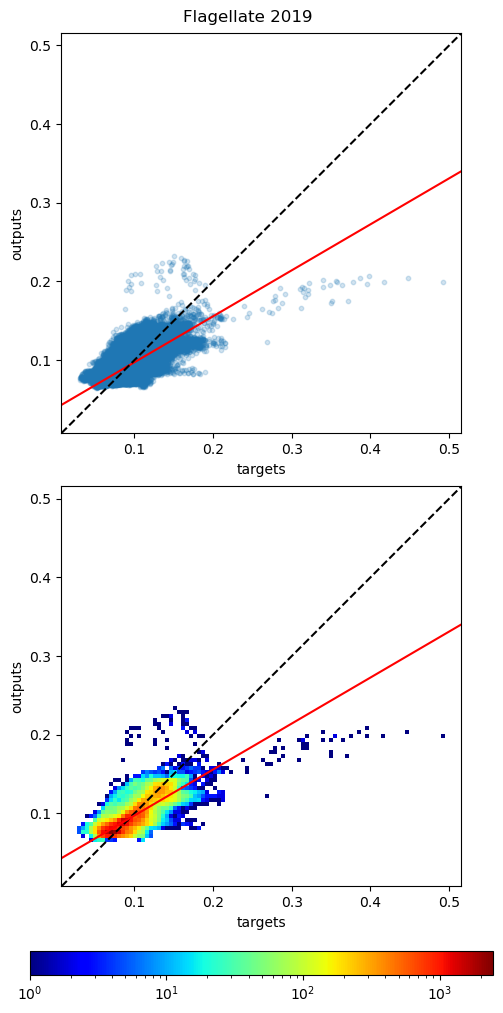

The amount of data points is 70794
The slope of the best fitting line is  0.353
The correlation coefficient is: 0.685
 The mean square error is: 0.00071357604


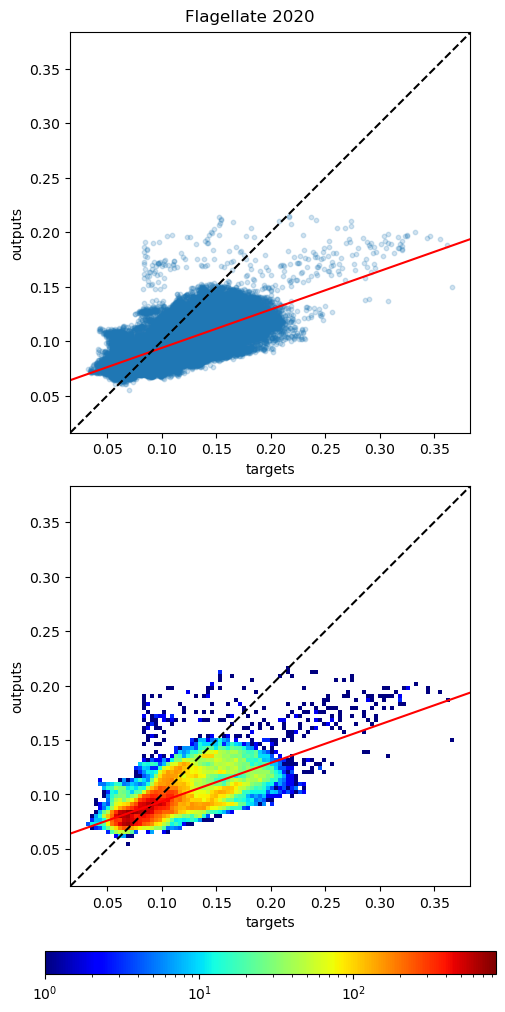

The amount of data points is 70794
The slope of the best fitting line is  0.56
The correlation coefficient is: 0.815
 The mean square error is: 0.00026431403


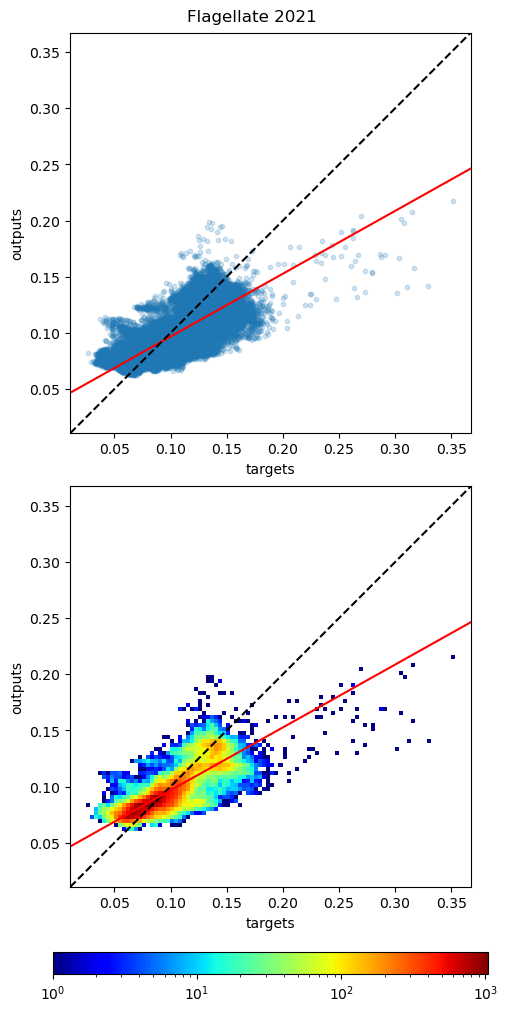

The amount of data points is 68931
The slope of the best fitting line is  0.68
The correlation coefficient is: 0.763
 The mean square error is: 0.0002430969


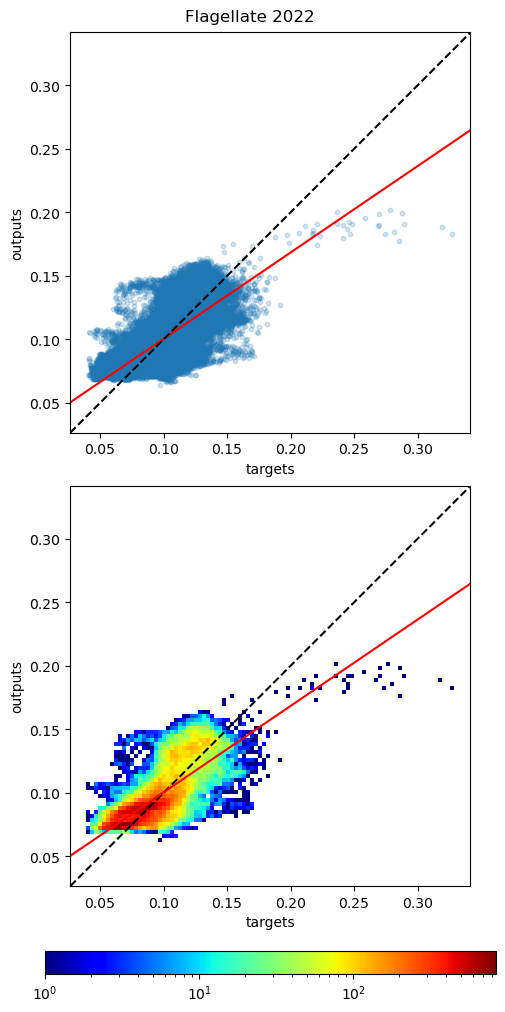

The amount of data points is 70794
The slope of the best fitting line is  0.409
The correlation coefficient is: 0.771
 The mean square error is: 0.0005688495


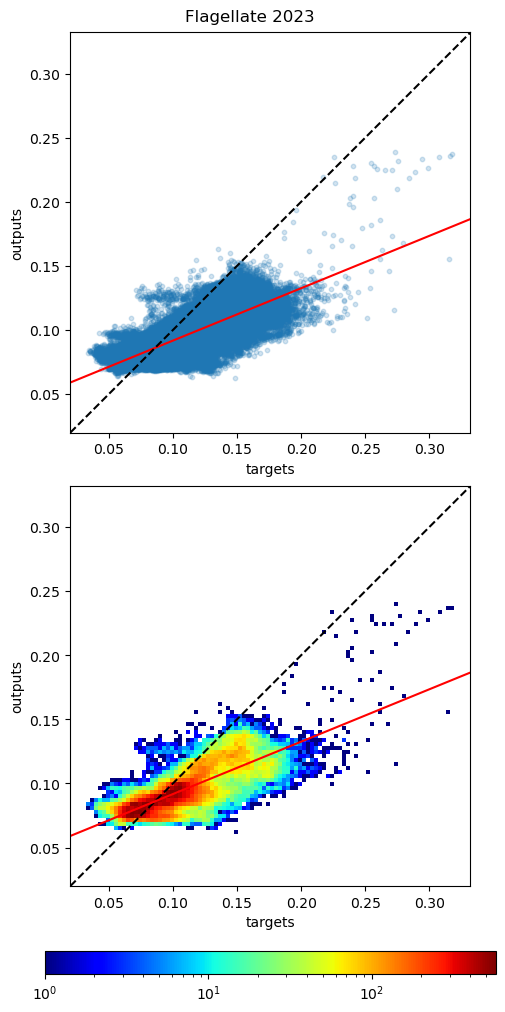

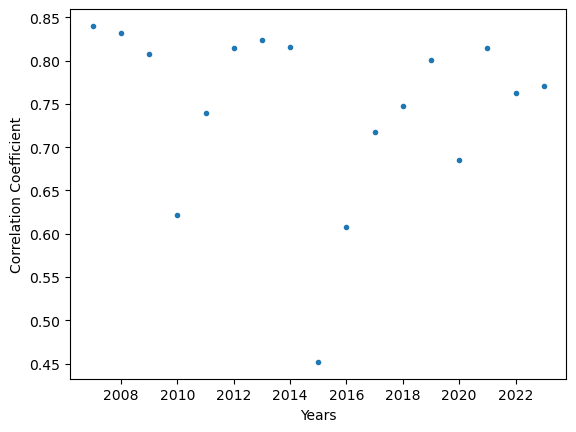

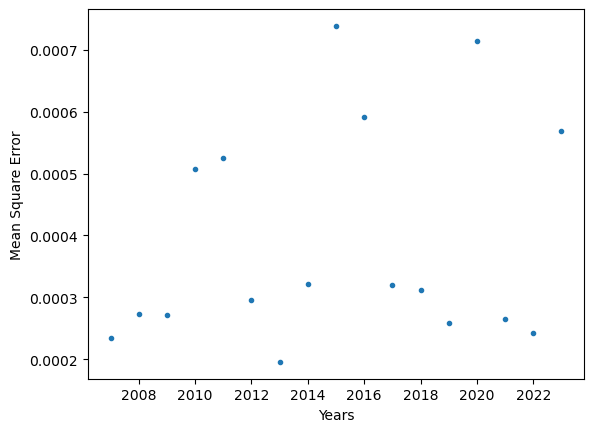

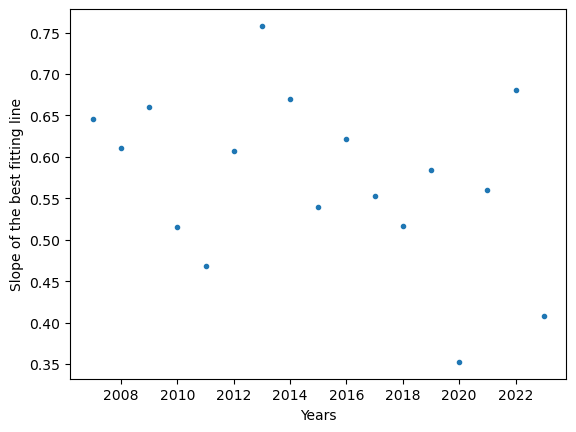

In [32]:
years = range (2007,2024)

r_all = []
rms_all = []
slope_all = []

for year in tqdm(range (2007,2024)):
    
    dataset = ds.sel(time_counter=str(year))
    
    drivers, flag, _ = datasets_preparation(dataset)

    r, rms, m = regressor2(drivers, flag, 'Flagellate ' + str(year))
    
    r_all.append(r)
    rms_all.append(rms)
    slope_all.append(m)
    
plotting(np.transpose(r_all), 'Correlation Coefficient')
plotting(np.transpose(rms_all), 'Mean Square Error')
plotting (np.transpose(slope_all), 'Slope of the best fitting line')


## Other Years (Daily)

  0%|          | 0/640 [00:00<?, ?it/s]

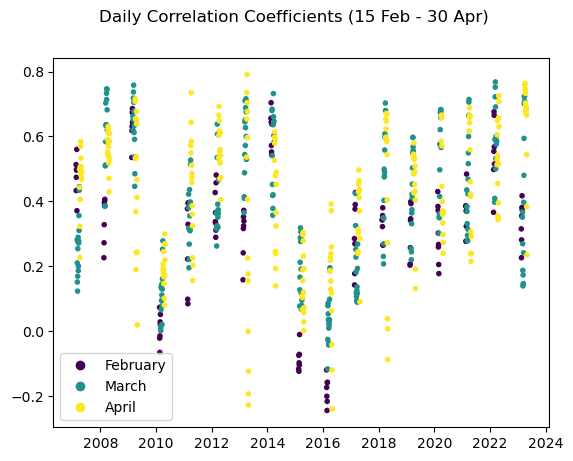

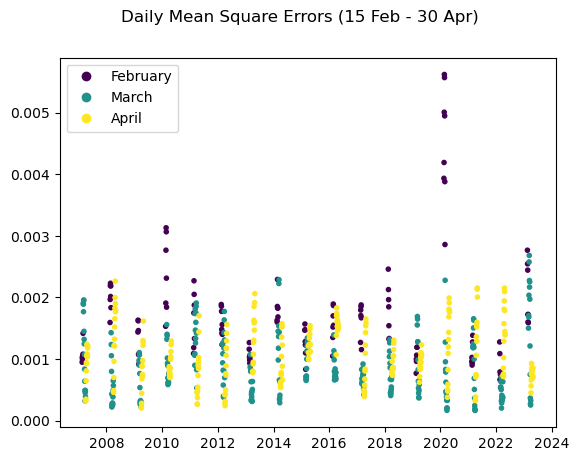

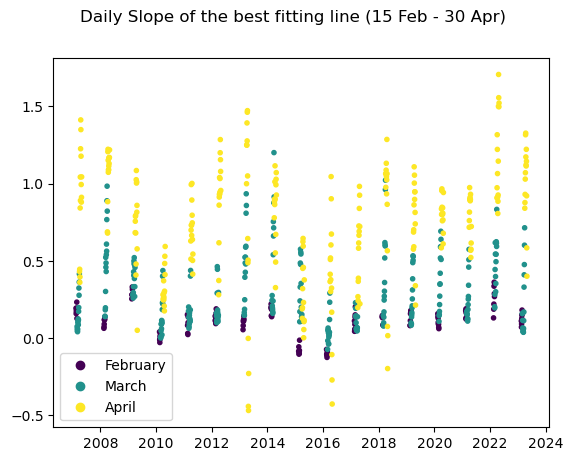

In [33]:
r_all2 = np.array([])
rms_all2 = np.array([])
slope_all2 = np.array([])

for i in tqdm(range (0, len(ds.time_counter))):
    
    dataset = ds.isel(time_counter=i)

    drivers, diat, _ = datasets_preparation(dataset)

    r, rms, m = regressor3(drivers, diat)

    r_all2 = np.append(r_all2,r)
    rms_all2 = np.append(rms_all2,rms)
    slope_all2 = np.append(slope_all2,m)

plotting2(r_all2, 'Correlation Coefficients')
plotting2(rms_all2, 'Mean Square Errors')
plotting2(slope_all2, 'Slope of the best fitting line')


## Daily Maps

  0%|          | 0/10 [00:00<?, ?it/s]

The amount of data points is 1863
The slope of the best fitting line is  0.678
The correlation coefficient is: 0.273
 The mean square error is: 0.0017826633


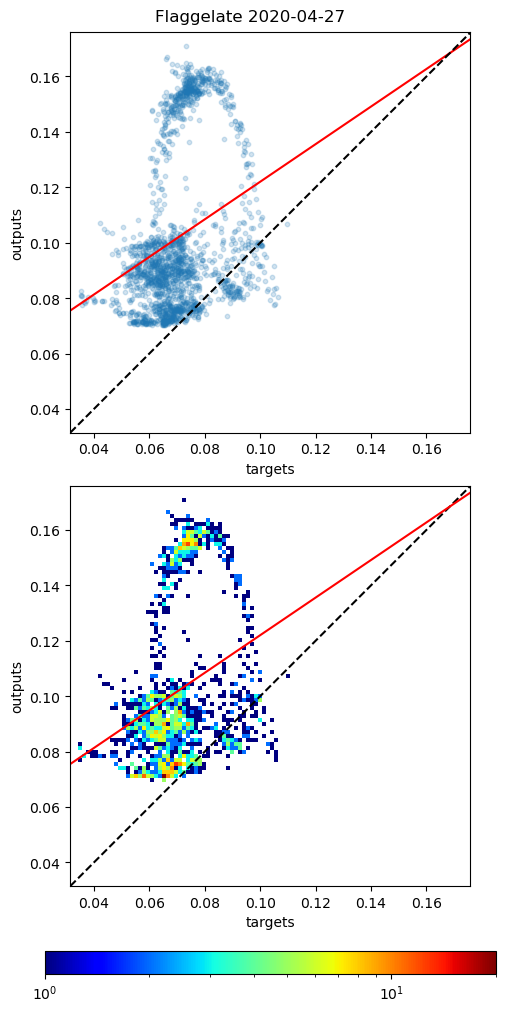

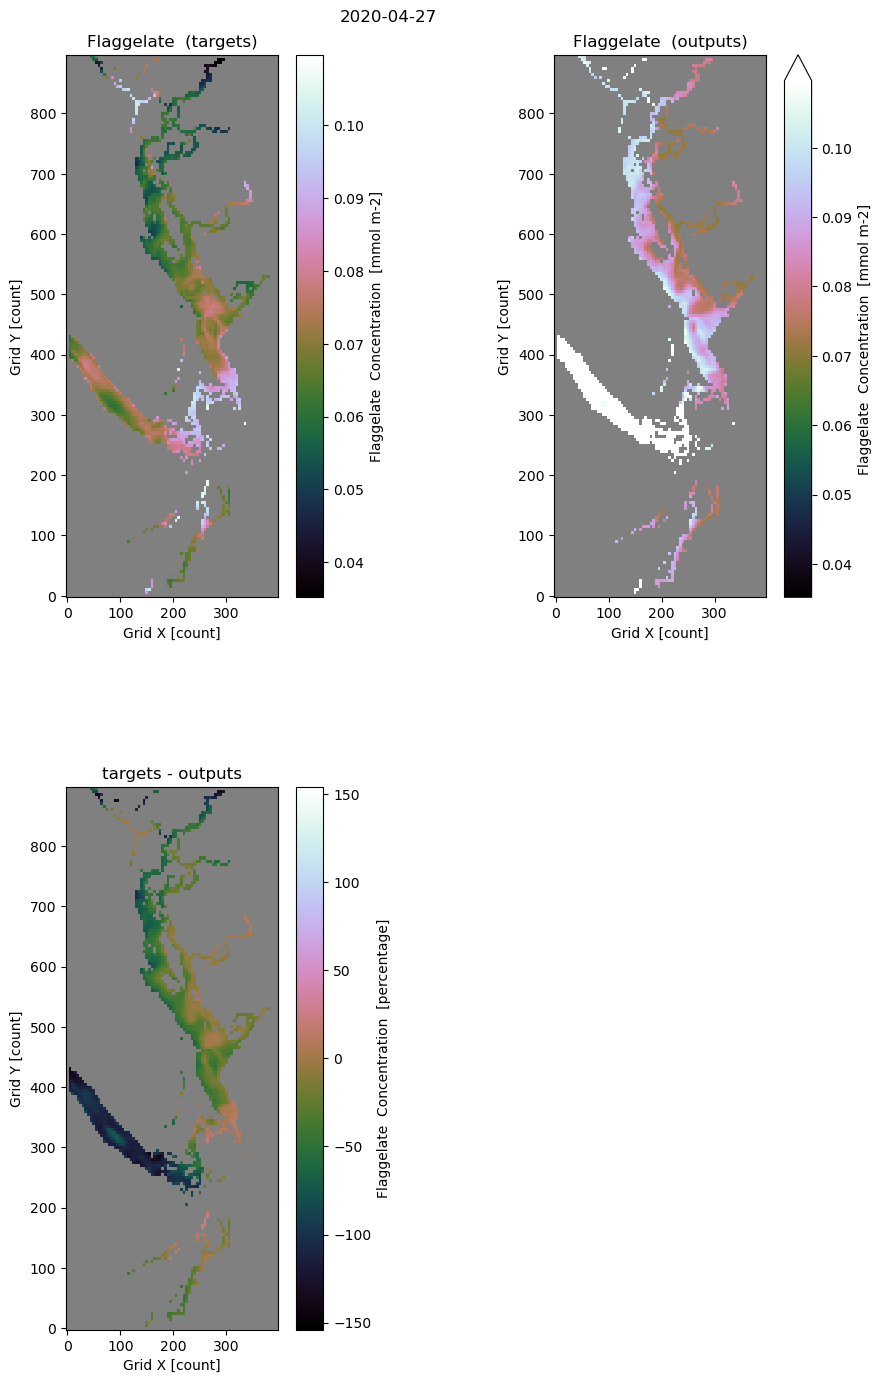

The amount of data points is 1863
The slope of the best fitting line is  0.132
The correlation coefficient is: 0.322
 The mean square error is: 0.0019640827


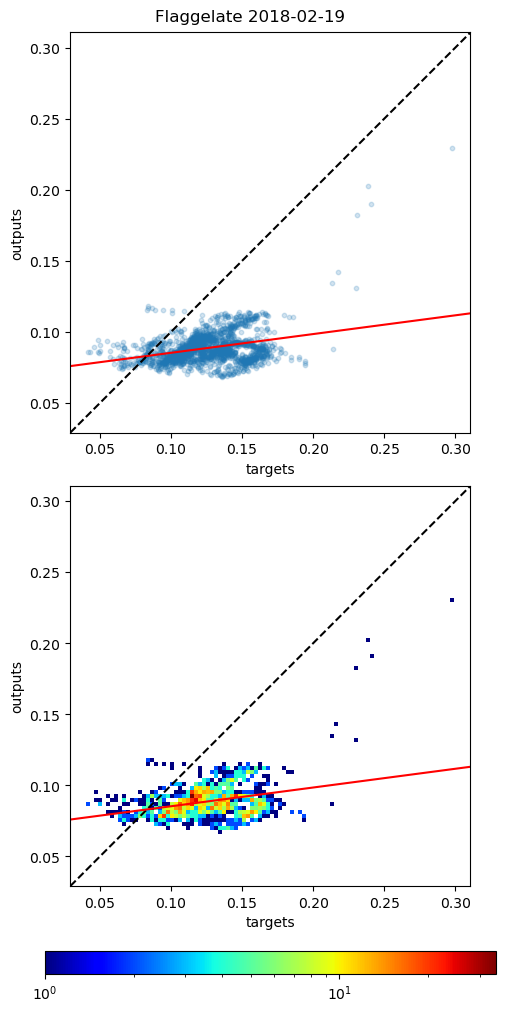

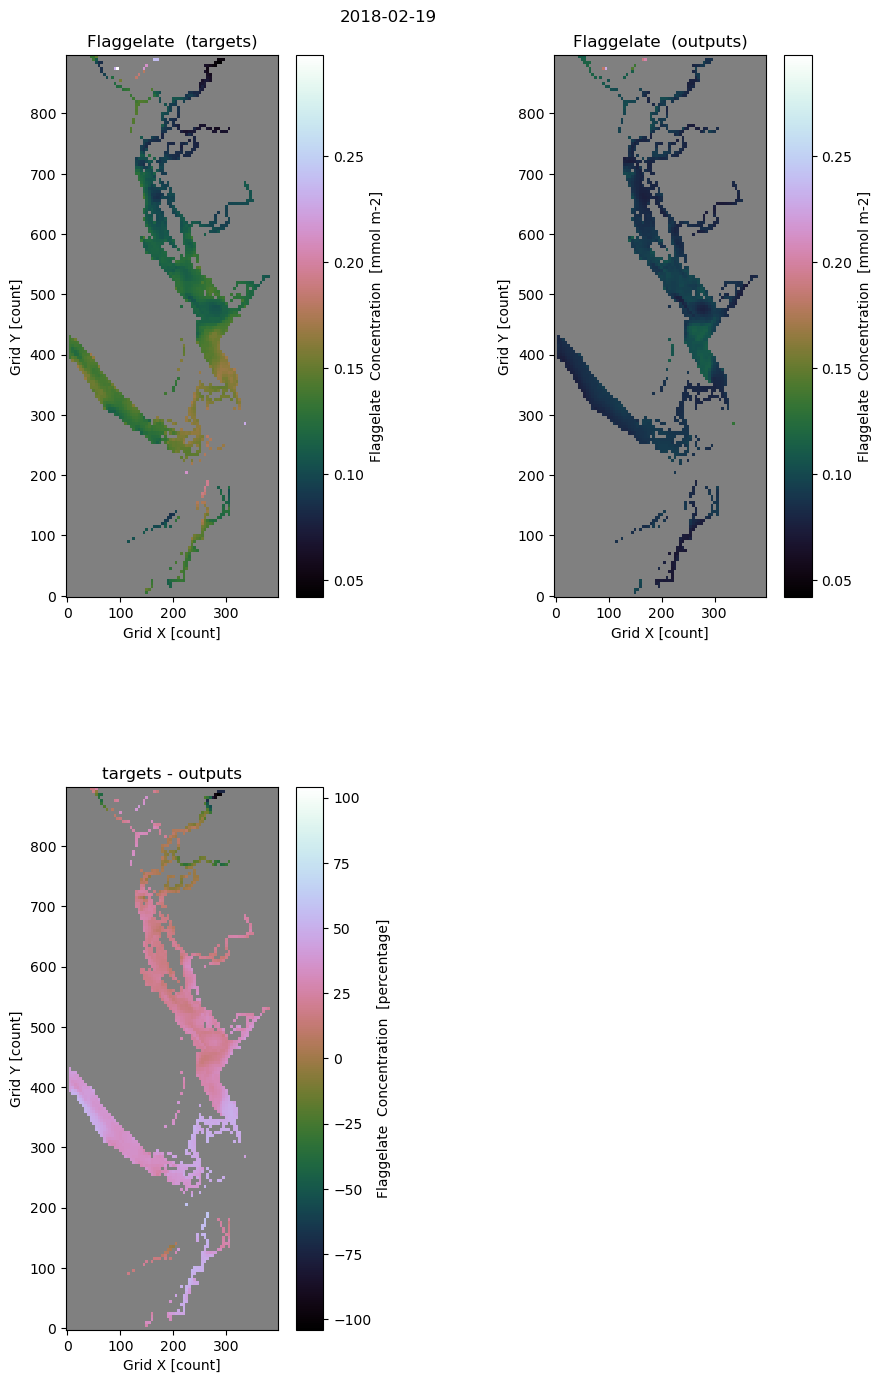

The amount of data points is 1863
The slope of the best fitting line is  1.155
The correlation coefficient is: 0.54
 The mean square error is: 0.0012960596


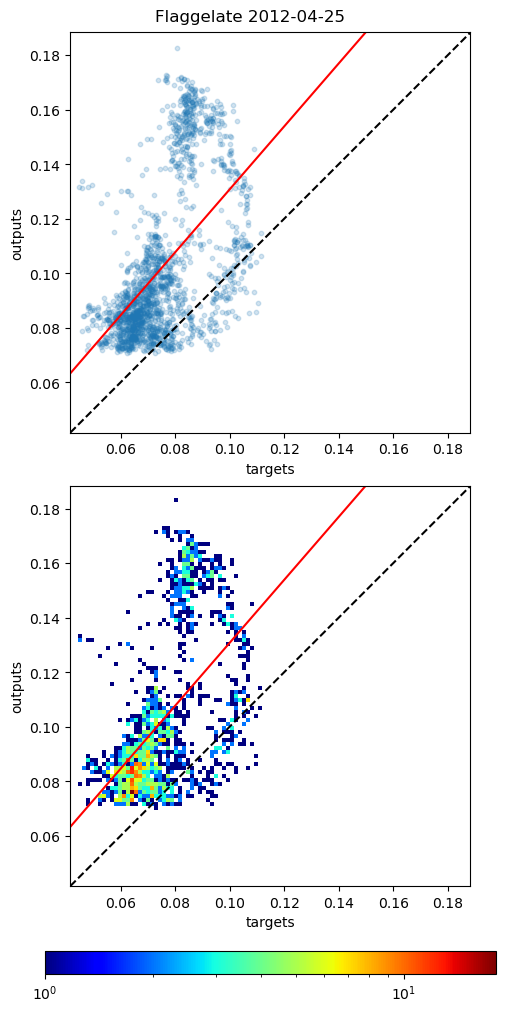

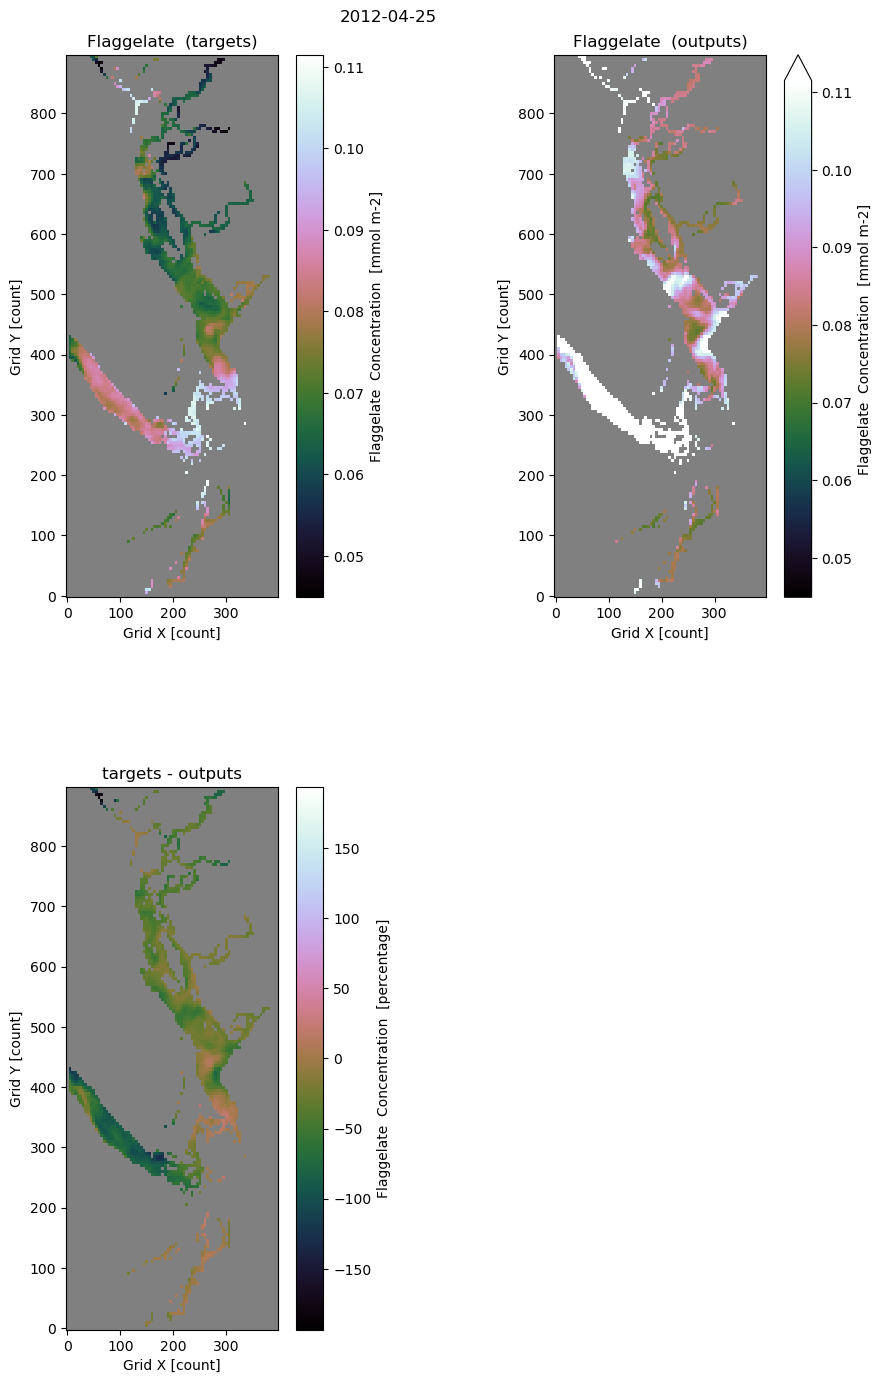

The amount of data points is 1863
The slope of the best fitting line is  0.942
The correlation coefficient is: 0.368
 The mean square error is: 0.0017622462


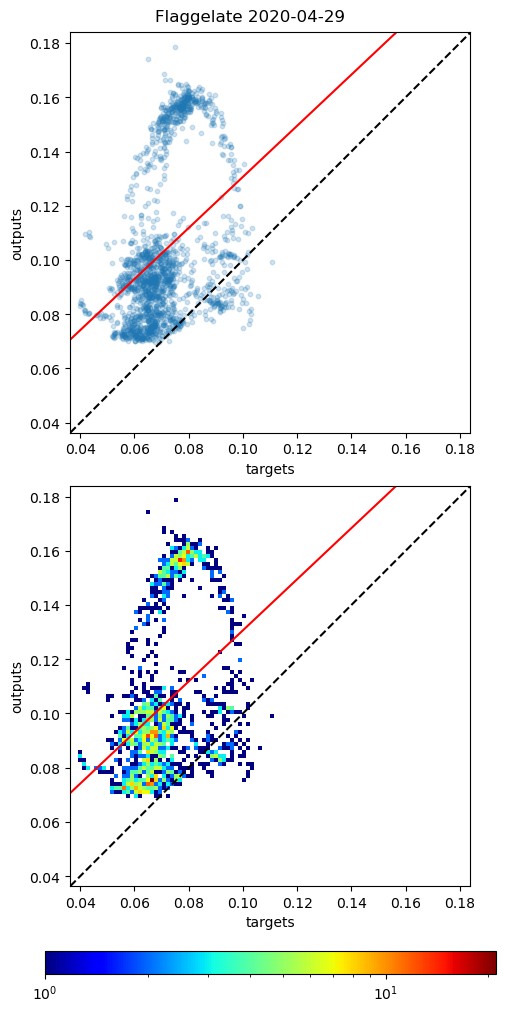

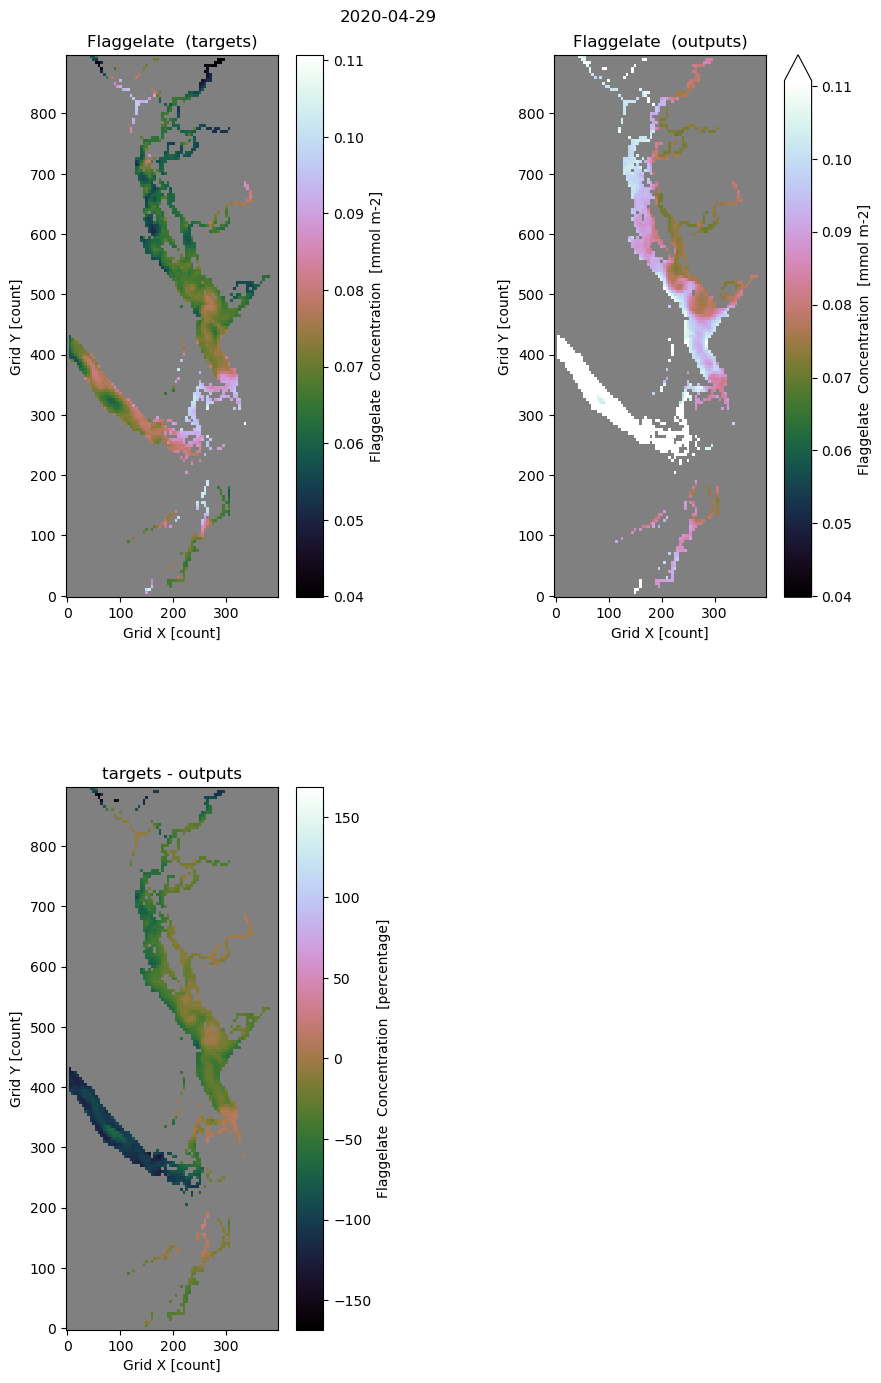

The amount of data points is 1863
The slope of the best fitting line is  0.304
The correlation coefficient is: 0.173
 The mean square error is: 0.0010370844


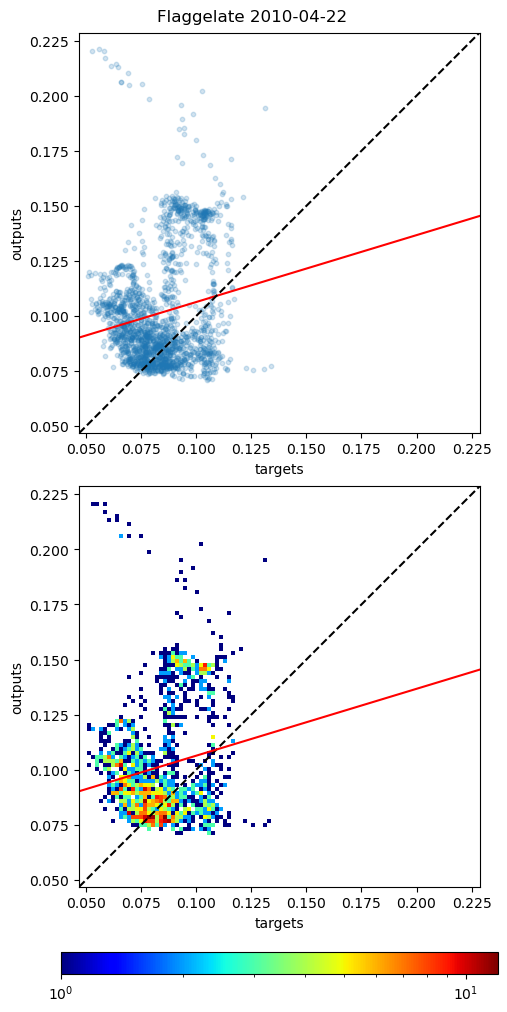

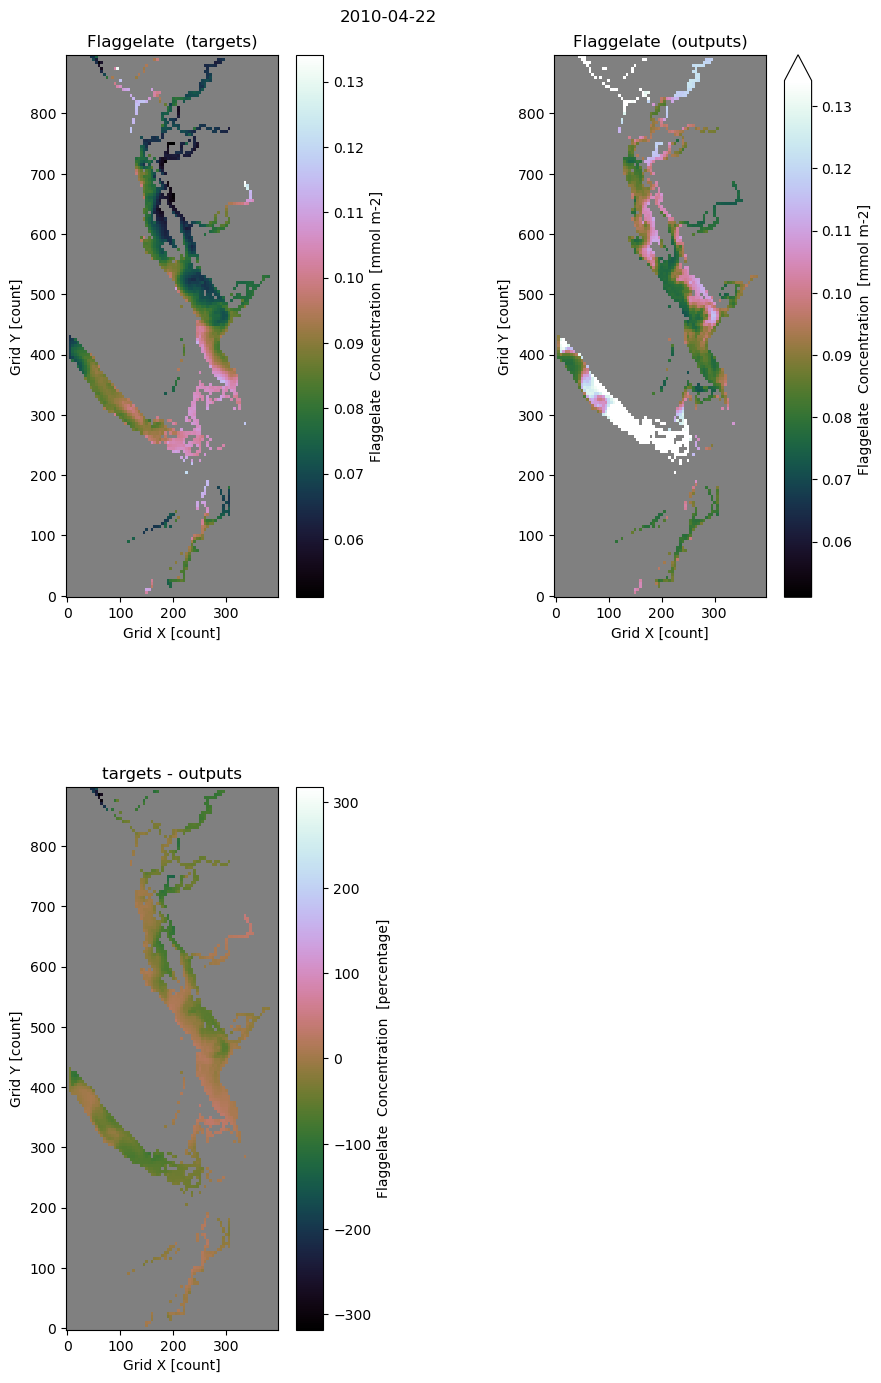

The amount of data points is 1863
The slope of the best fitting line is  0.157
The correlation coefficient is: 0.43
 The mean square error is: 0.0039337426


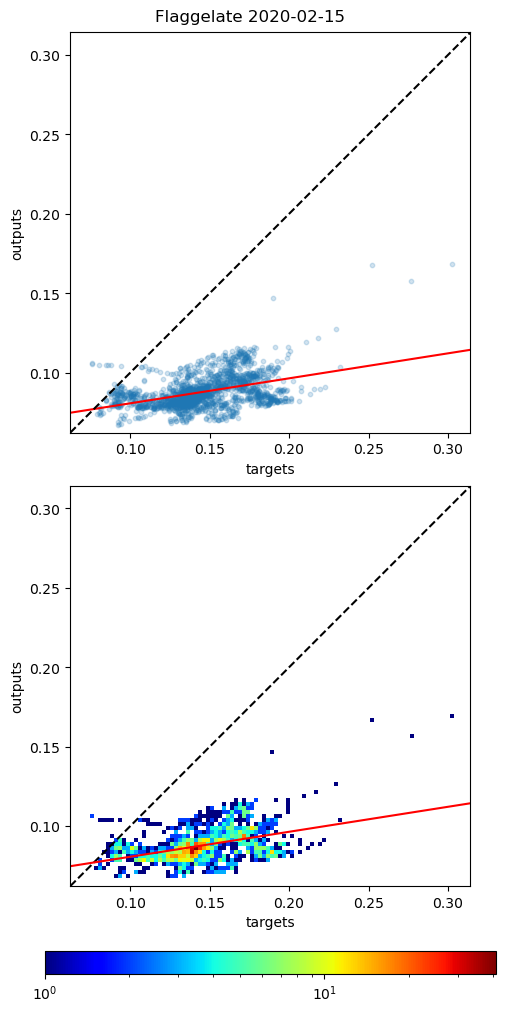

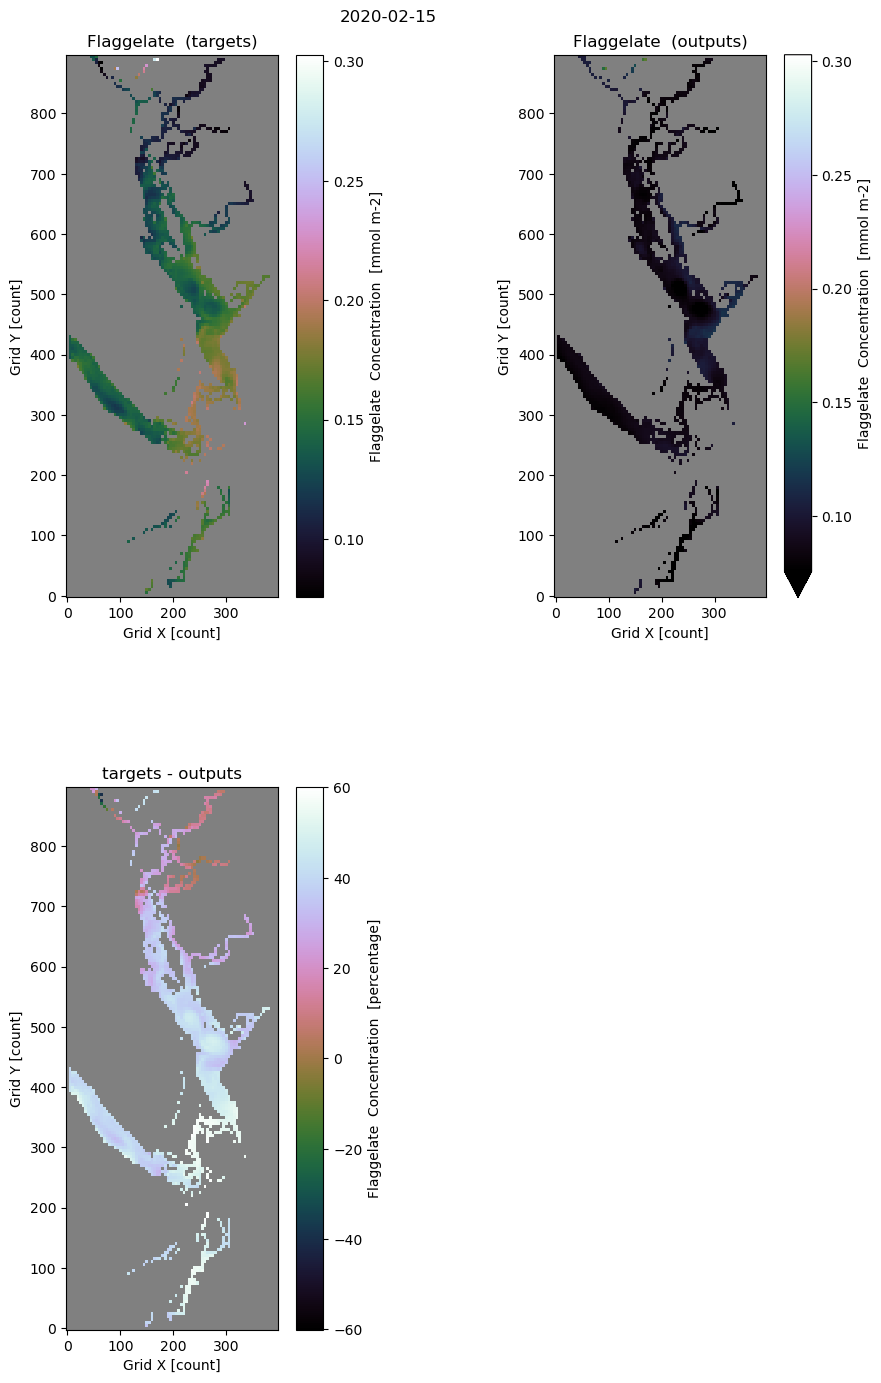

The amount of data points is 1863
The slope of the best fitting line is  0.113
The correlation coefficient is: 0.257
 The mean square error is: 0.0009626599


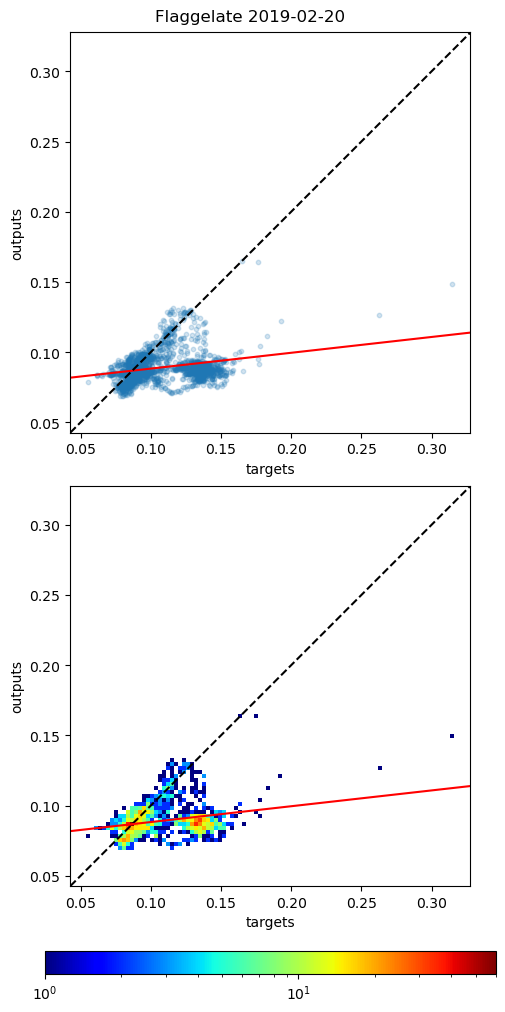

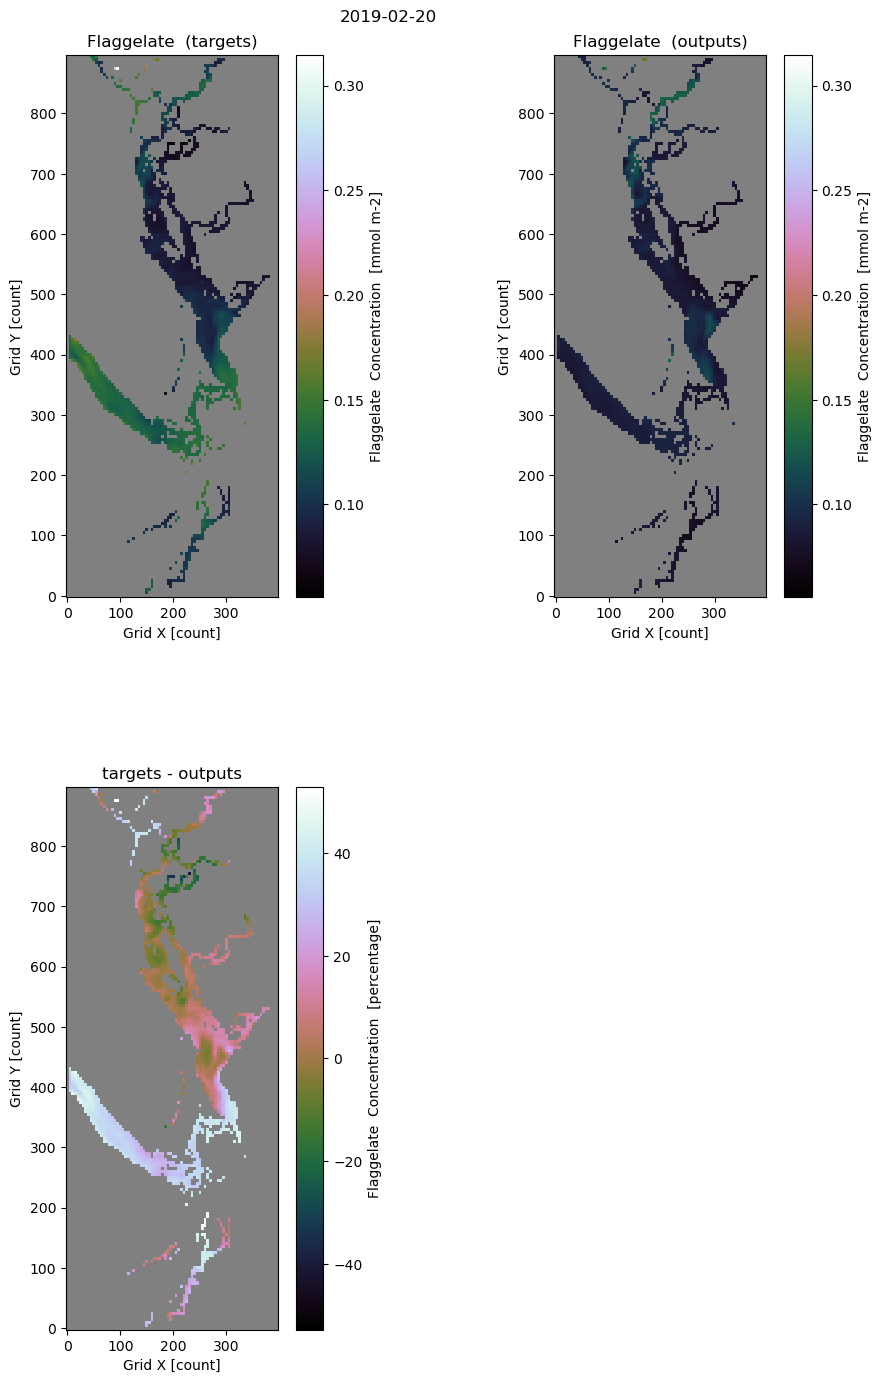

The amount of data points is 1863
The slope of the best fitting line is  1.286
The correlation coefficient is: 0.67
 The mean square error is: 0.00085554115


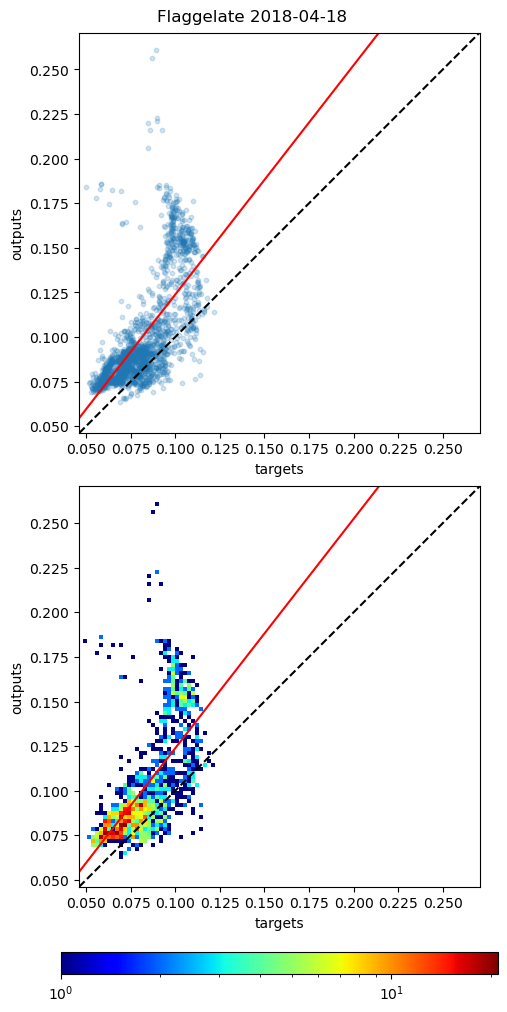

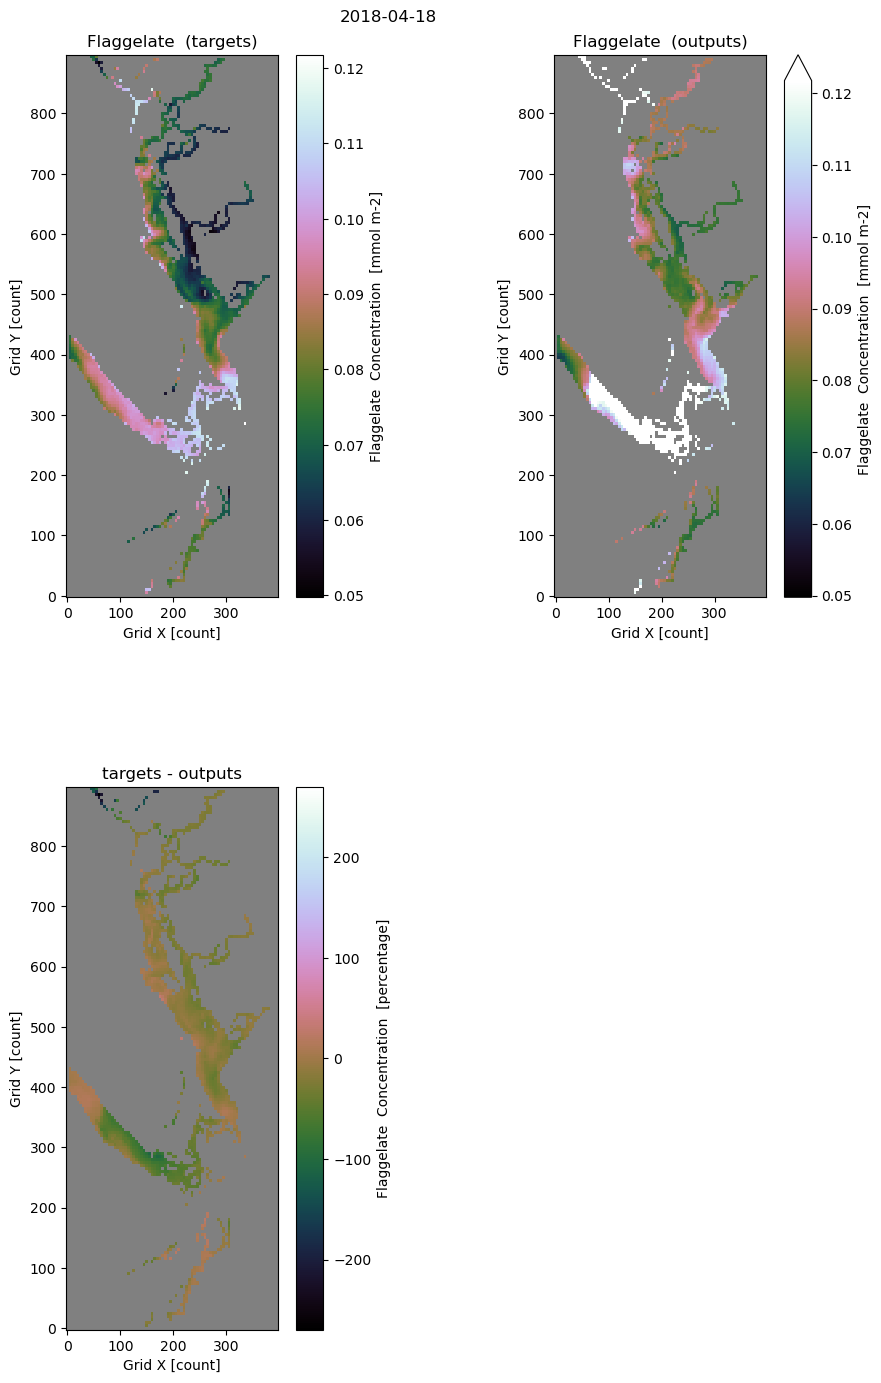

The amount of data points is 1863
The slope of the best fitting line is  0.165
The correlation coefficient is: 0.414
 The mean square error is: 0.00085254345


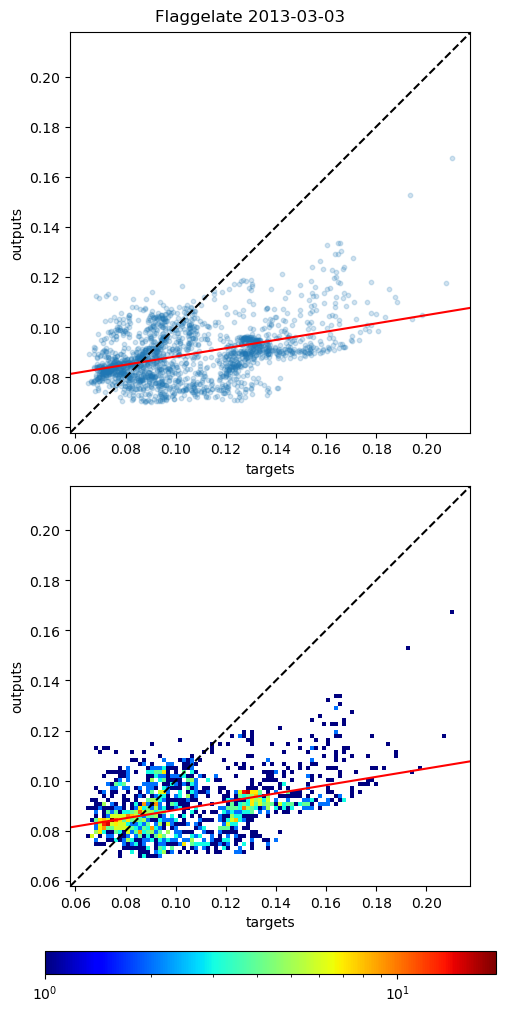

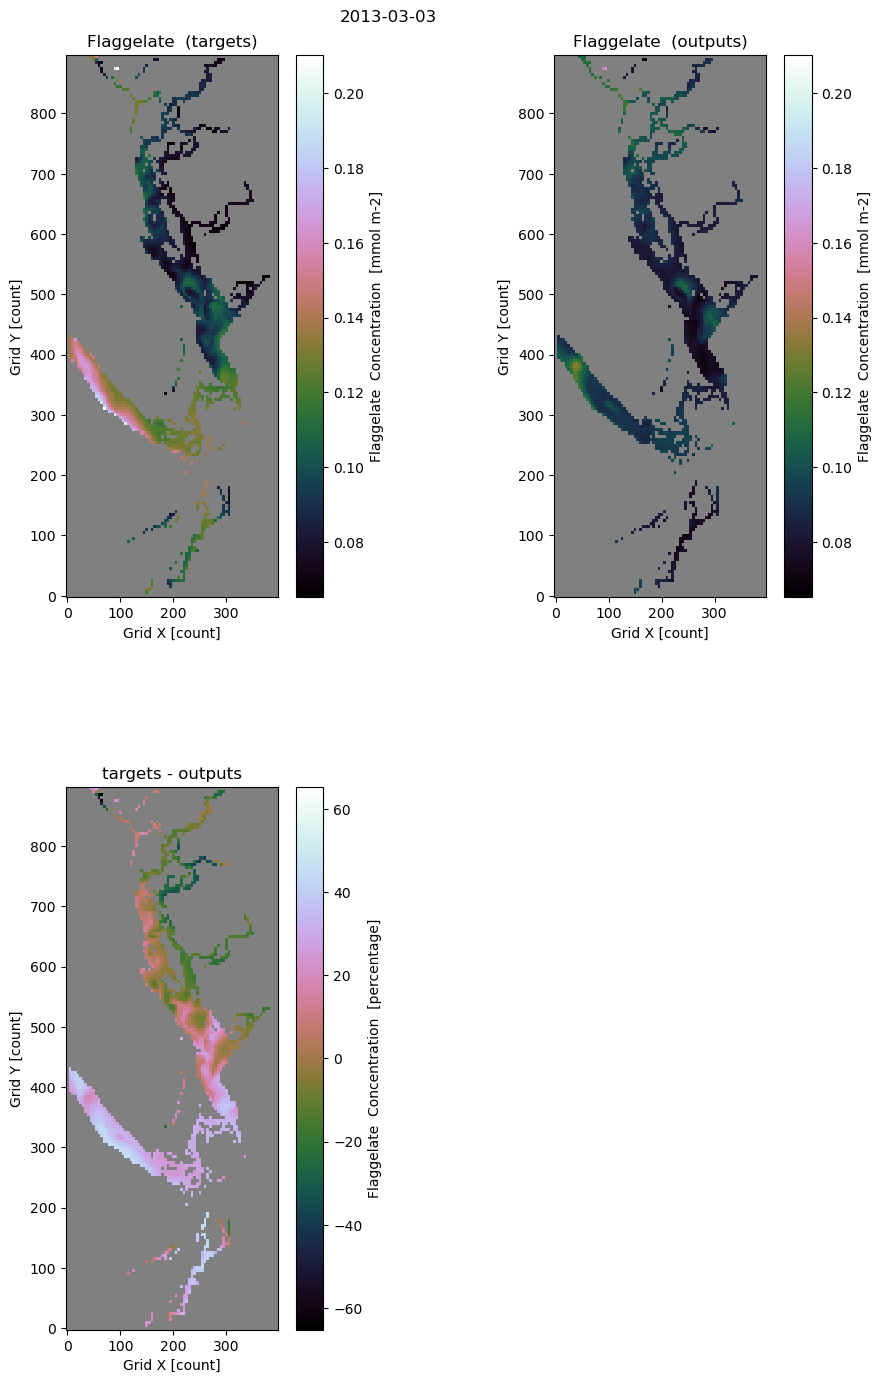

The amount of data points is 1863
The slope of the best fitting line is  0.1
The correlation coefficient is: 0.329
 The mean square error is: 0.0020499136


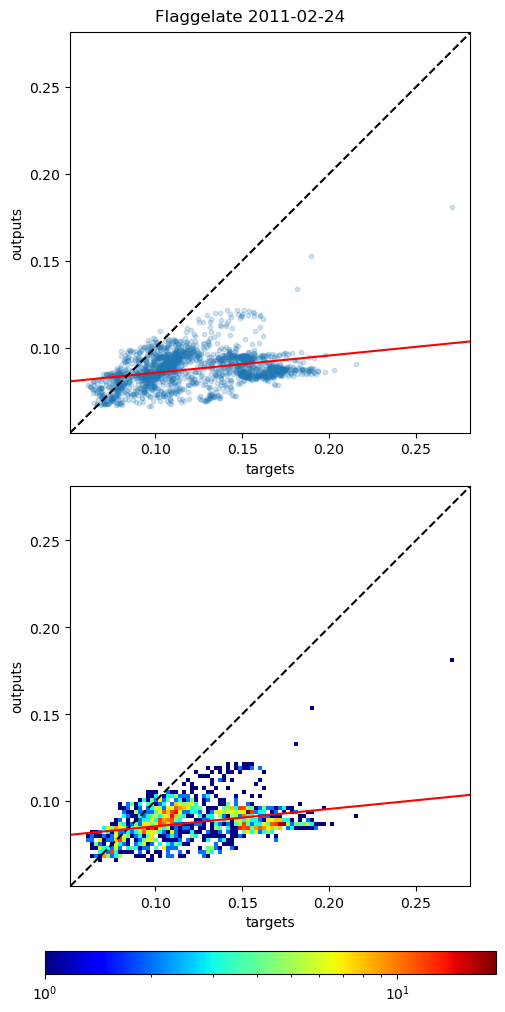

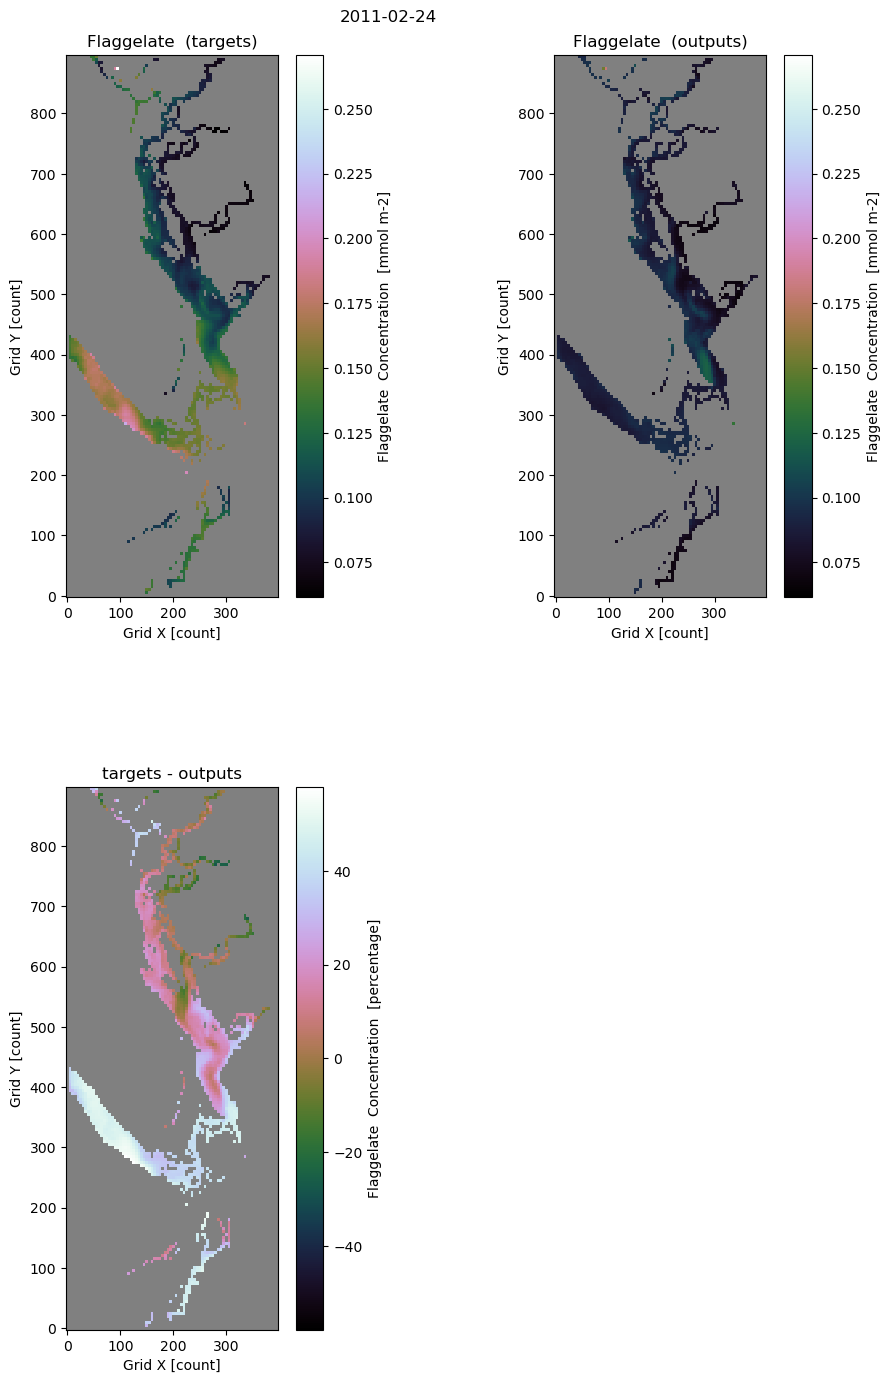

In [35]:
maps = random.sample(range(0,len(ds.time_counter)),10)

for i in tqdm(maps):

    dataset = ds.isel(time_counter=i)
    drivers, flag, indx = datasets_preparation(dataset)

    flag_i = dataset['Flagellate']

    regressor4(drivers, flag, 'Flaggelate ')
